In [1]:
## STANDARD IMPORTS
import os
import time
import h5py
import numpy as np
import numpy.ma as ma
import pandas as pd
import json

!pip3 install ../h5flow
import h5flow
from h5flow.data import dereference

## 3D PLOTTING
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm

Defaulting to user installation because normal site-packages is not writeable
Processing /global/u1/j/jvmead/dune/h5flow
  Preparing metadata (setup.py) ... done
  Created wheel for h5flow: filename=h5flow-0.2.4-py3-none-any.whl size=31486 sha256=279db4dcd03997b13b040d1aace9e7f0687f403316a724f8f449b6cc4dcaabac
  Stored in directory: /tmp/pip-ephem-wheel-cache-b7_3t524/wheels/0c/cb/86/6b657de7e9cca14c751cd866f4b2a2bfe75dd32620aa8569ce
Successfully built h5flow
  Attempting uninstall: h5flow
    Found existing installation: h5flow 0.2.4
    Uninstalling h5flow-0.2.4:
      Successfully uninstalled h5flow-0.2.4


In [2]:
def plot_summed_waveform_with_interactions(time_bins, wvfm, height, hits, i_mask=None, i_evt=None, xlim = (0, 16), logy=False, print_int_times=False):
  # plot the waveform
  fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

  # convert i_mask into TPC and TrapType
  if i_mask is not None:
    tpc = i_mask // 2
    trap_type = i_mask % 2
    if trap_type == 0:
      trap_type = 'ACL'
    else:
      trap_type = 'LCM'
    ax1.set_title(f'TPC {tpc} TrapType {trap_type}')

  if i_mask is not None and i_evt is not None:
    ax1.set_title(f'TPC {i_mask} Event {i_evt}')

  ylabel = 'ADC - baseline'
  sqrt_height = np.sqrt(height)
  if logy:
    wvfm+=1
    height+=1
    ylabel+=' + 1'
    ax1.set_yscale('log')
    ax1.set_ylim(0.99, 1.1 * np.max(wvfm))

  # Linear y-axis plot
  ax1.plot(time_bins * 1e6, wvfm, color='black')
  ax1.set_ylabel(ylabel)

  # plot noise floor
  ax1.axhline(height, color='r', linestyle='--')

  # peaks for interactions
  ax1.plot(time_bins[hits] * 1e6, wvfm[hits], 'x', color='red', label='Interactions')
  if print_int_times:
    for hit in hits:
      ax1.text(time_bins[hit] * 1e6, wvfm[hit], f'{time_bins[hit]*1e6:.2f}', color='red')

  # formatting
  ax1.set_xlim(xlim)
  ax1.set_ylim(2 * np.min(wvfm), 1.1 * np.max(wvfm))
  ax1.axvspan(-1, -1, color='green', alpha=0.1, label='ToT')
  ax1.legend()

  plt.show()

In [3]:
dirname = 'data_processed_mpd_run_hvramp_rctl_105_p350.FLOW_TrapType_evts_all'
spes_filename = dirname+'/spes_evt.npz'
noise_filename = dirname+'/noise_evt.npz'
config_filename = dirname+'/config.json'
hits_filename = dirname+'/hits_evt.npz'
hits_config_filename = dirname+'/hits_config.json'

# print configuration and hit configuration
with open(config_filename) as json_file:
    config = json.load(json_file)
    print(json.dumps(config, indent=4))
with open(hits_config_filename) as json_file:
    hits_config = json.load(json_file)
    print(json.dumps(hits_config, indent=4))

{
    "timestamp": "2025-02-25 04:45:09.660790",
    "filename": "/global/cfs/cdirs/dune/www/data/2x2/nearline/flowed_light/data_bin004/mpd_run_hvramp_rctl_105_p350.FLOW.hdf5",
    "is_data": true,
    "save_truth": false,
    "summed": "TrapType",
    "max_evts": null,
    "calib_filename": "calibration/data_calib.csv",
    "geom_filename": "geom_files/light_module_desc-5.0.0.csv",
    "channel_status_filename": "channel_status/channel_status.csv",
    "maskfile": "channel_sum_masks/TrapType_masks_data.npz"
}
{
    "n_noise_factor": 5.0,
    "n_bins_rolled": 10,
    "n_sqrt_rt_factor": 5.0,
    "pe_weight": 1.0
}


[433]


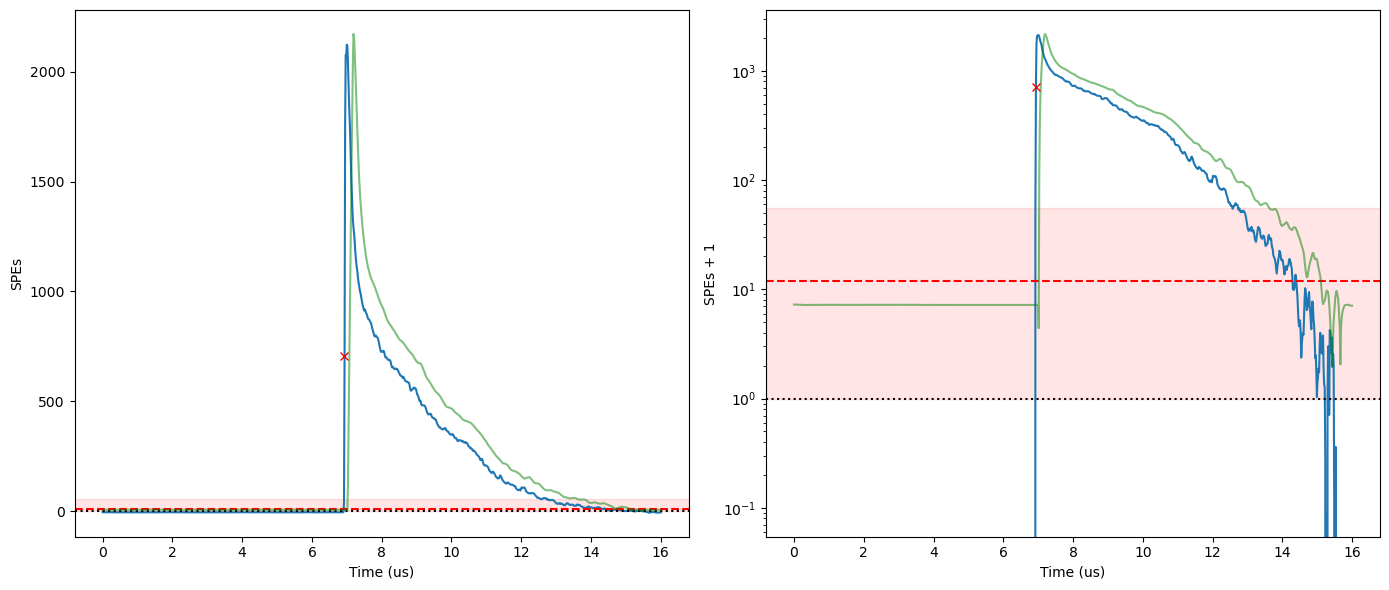

In [4]:
from scipy.ndimage import uniform_filter1d

# load hit finder config
with open(hits_config_filename) as json_file:
    hits_config = json.load(json_file)
n_noise_factor = hits_config['n_noise_factor']
n_bins_rolled = hits_config['n_bins_rolled']
n_sqrt_rt_factor = hits_config['n_sqrt_rt_factor']
pe_weight = hits_config['pe_weight']


# loading events
time_bins = np.linspace(0, 16, 1000)

# wvfms
summed_wvfms_file = np.load(spes_filename)
summed_wvfms = np.array(summed_wvfms_file['arr_0'])

# noise thresholds
heights_file = np.load(noise_filename)
heights = np.array(heights_file['arr_0'])

# loading hits
hits_file = np.load(hits_filename)
hits = np.array(hits_file['arr_0'])

# find first event with hits != -1
i_mask = 7 # 2 * TPC + TrapType
i_evt_lrs = 3705 # event number

# get wvfm, threshold, and hits for the event
wvfm = summed_wvfms[i_evt_lrs,i_mask]
wvfm_rolled = np.roll(wvfm, n_bins_rolled)
rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
height = heights[i_evt_lrs,i_mask]
hit = hits[i_evt_lrs,i_mask]
hit_where = np.where(hit)[0]
print(hit_where)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Linear plot
ax1.plot(time_bins, wvfm)
ax1.axhline(height, color='r', linestyle='--')
ax1.axhspan(0,n_noise_factor*height, color='r', alpha=0.1)
ax1.axhline(0, color='k', linestyle=':')
ax1.plot(time_bins, dynamic_threshold, color='g', alpha=0.5)
ax1.plot(hit_where * 16/1000, wvfm[hit_where], 'x', color='red')
ax1.set_xlabel('Time (us)')
ax1.set_ylabel('SPEs')

# Logarithmic plot
ax2.plot(time_bins, wvfm + 1)
ax2.axhline(height + 1, color='r', linestyle='--')
ax2.axhspan(1,n_noise_factor*height+1, color='r', alpha=0.1)
ax2.axhline(1, color='k', linestyle=':')
ax2.plot(time_bins, dynamic_threshold + 1, color='g', alpha=0.5)
ax2.plot(hit_where * 16/1000, wvfm[hit_where] + 1, 'x', color='red')
ax2.set_yscale('log')
ax2.set_xlabel('Time (us)')
ax2.set_ylabel('SPEs + 1')

plt.tight_layout()
plt.show()

Event 9, TPC 4, TrapType 1


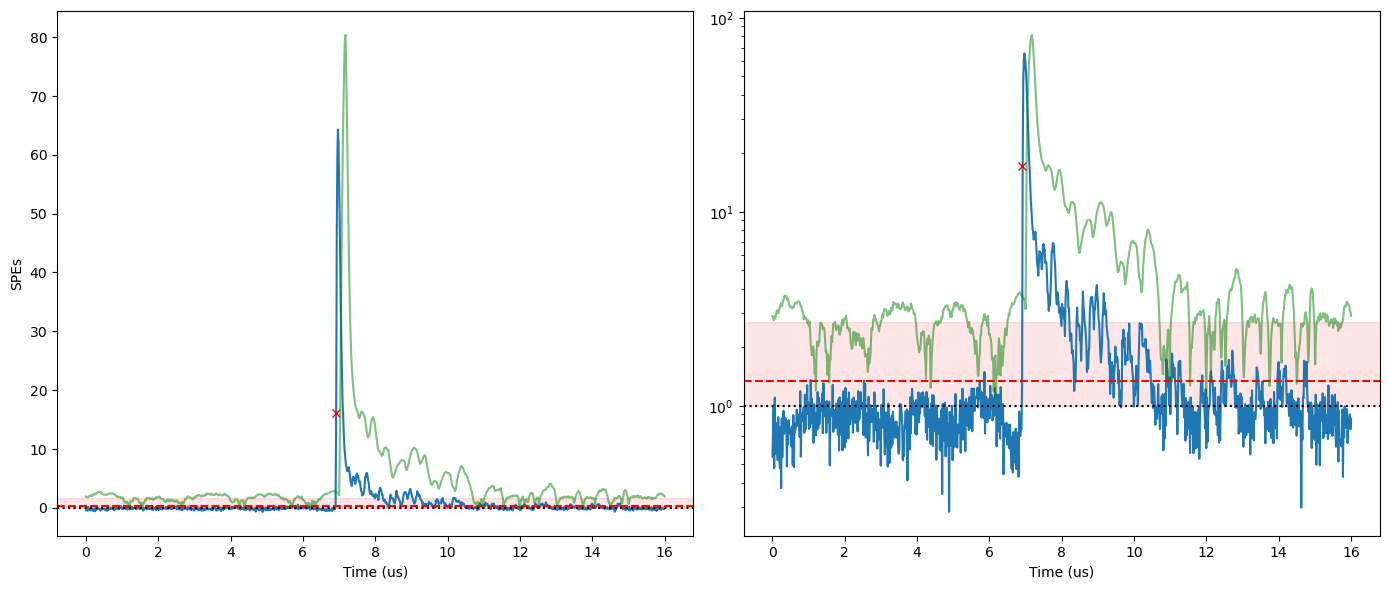

In [5]:
# plot the waveform of the trap with the highest wvfm in the event
for i_evt in range(10):

  # skip events with no hits
  all_traps = summed_wvfms[i_evt_lrs]
  all_heights = heights[i_evt_lrs]
  all_hits = hits[i_evt_lrs]

  # mask with the most hits
  i_mask = np.argmax(all_hits.sum(axis=1))
  i_evt_lrs = i_evt

  # get wvfm, threshold, and hits for the event
  wvfm = summed_wvfms[i_evt_lrs,i_mask]
  wvfm_rolled = np.roll(wvfm, n_bins_rolled)
  rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
  sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
  dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
  height = heights[i_evt_lrs,i_mask]
  hit = hits[i_evt_lrs,i_mask]
  hit_where = np.where(hit)[0]
  if len(hit_where) == 0:
    continue
  print(f'Event {i_evt_lrs}, TPC {i_mask // 2}, TrapType {i_mask % 2}')

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

  # Linear plot
  ax1.plot(time_bins, wvfm)
  ax1.axhline(height, color='r', linestyle='--')
  ax1.axhspan(0,n_noise_factor*height, color='r', alpha=0.1)
  ax1.axhline(0, color='k', linestyle=':')
  ax1.plot(time_bins, dynamic_threshold, color='g', alpha=0.5)
  ax1.plot(hit_where * 16/1000, wvfm[hit_where], 'x', color='red')
  ax1.set_xlabel('Time (us)')
  ax1.set_ylabel('SPEs')

  # Logarithmic plot
  ax2.plot(time_bins, wvfm + 1)
  ax2.axhline(height + 1, color='r', linestyle='--')
  ax2.axhspan(1,n_noise_factor*height+1, color='r', alpha=0.1)
  ax2.axhline(1, color='k', linestyle=':')
  ax2.plot(time_bins, dynamic_threshold + 1, color='g', alpha=0.5)
  ax2.plot(hit_where * 16/1000, wvfm[hit_where] + 1, 'x', color='red')
  ax2.set_yscale('log')
  ax2.set_xlabel('Time (us)')

  plt.tight_layout()
  plt.show()

In [6]:
# plotting script to plot the summed traptype waveforms per tpc with interactions
def plot_summed_trap_waveform_per_tpc_with_interactions(i_evt, time_bins, summed_wvfms, hits):

  # 2x2 TPC subplot grid, each with traptype sum waveforms
  fig, axs = plt.subplots(8, 1, figsize=(15, 15))

  for tpc in range(8):
    acl_mask = 2*tpc
    lcm_mask = 2*tpc + 1

    axs[tpc].axhline(0, color='k', linestyle=':')

    # get wvfm, threshold, and hits for the event
    acl_wvfm = summed_wvfms[i_evt, acl_mask]
    acl_hit = hits[i_evt, acl_mask]
    acl_hit_where = np.where(acl_hit)[0]

    lcm_wvfm = summed_wvfms[i_evt, lcm_mask]
    lcm_hit = hits[i_evt, lcm_mask]
    lcm_hit_where = np.where(lcm_hit)[0]

    axs[tpc].plot(time_bins, acl_wvfm, label='ACL', color='red', alpha=0.5)
    axs[tpc].plot(acl_hit_where * 16/1000, acl_wvfm[acl_hit_where], 'x', color='red')

    axs[tpc].plot(time_bins, lcm_wvfm, label='LCM', color='blue', alpha=0.5)
    axs[tpc].plot(lcm_hit_where * 16/1000, lcm_wvfm[lcm_hit_where], 'x', color='blue')

    axs[tpc].set_xlabel('Time (us)')
    axs[tpc].set_ylabel('SPEs')
    axs[tpc].set_title(f'TPC {tpc}')

    # legend
    axs[tpc].legend()

  plt.tight_layout()
  plt.show()

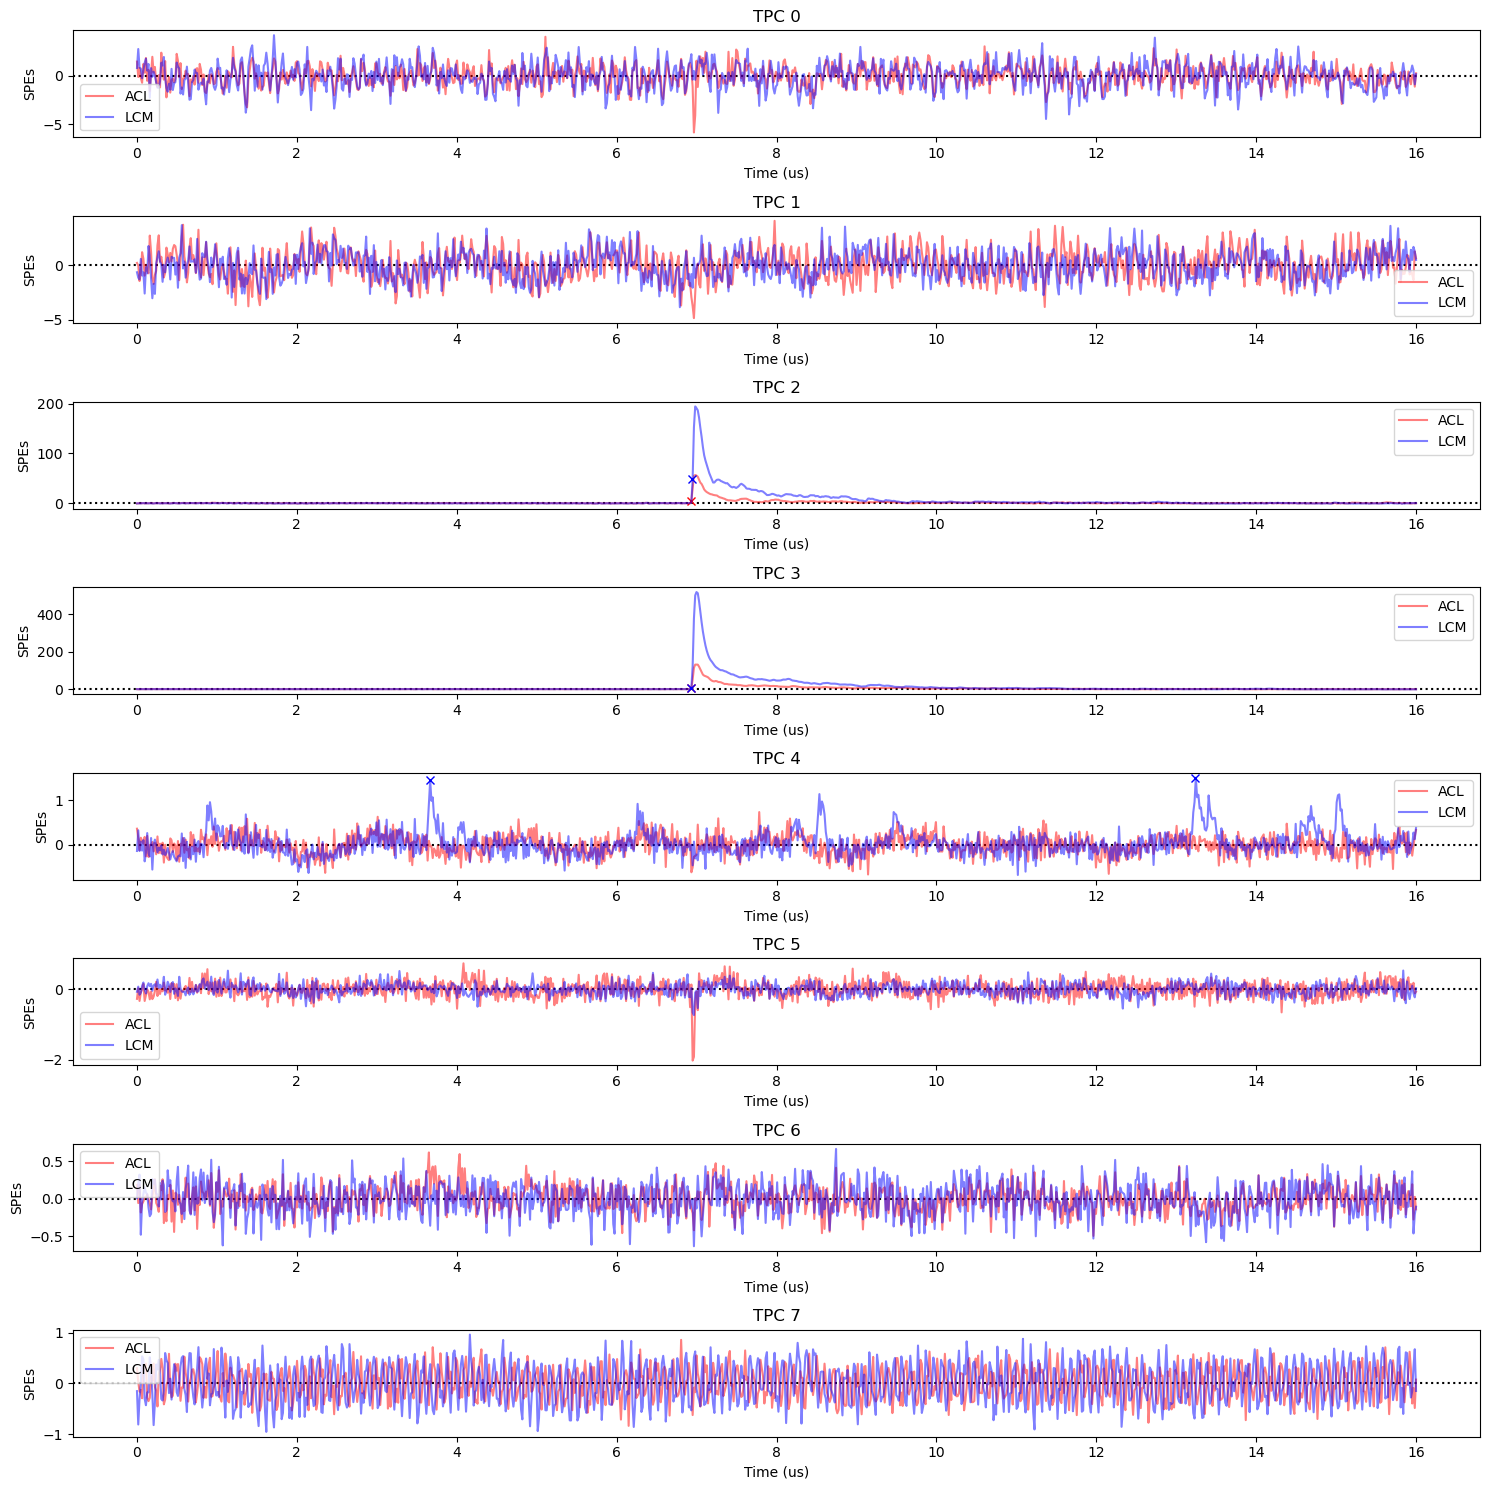

In [7]:
# test
i_evt = 3000

plot_summed_trap_waveform_per_tpc_with_interactions(i_evt, time_bins, summed_wvfms, hits)
